In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error

In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
np.random.seed(7)

#Carrega o dataset
dataframe = read_csv('https://telescopeinstorage.blob.core.windows.net/datasets/Eletrical_Production.csv', index_col = 'DATE', engine='python')
dataframe.head(150)

,IPG2211A2N
DATE,
1939-01-01,3.3842
1939-02-01,3.4100
1939-03-01,3.4875
1939-04-01,3.5133
1939-05-01,3.5133
...,...
1951-02-01,10.2817
1951-03-01,10.2817
1951-04-01,10.2559


In [ ]:
dataframe.tail(150)

,IPG2211A2N
DATE,
2006-11-01,92.5922
2006-12-01,103.3658
2007-01-01,112.3854
2007-02-01,112.1298
2007-03-01,99.4690
...,...
2018-12-01,112.9498
2019-01-01,123.7679
2019-02-01,113.0855


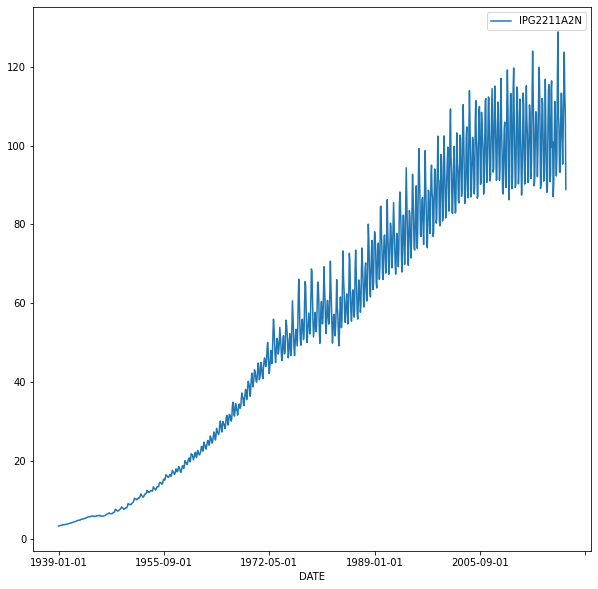

In [ ]:
dataframe.plot(figsize=(10,10))

In [ ]:
dataframeFilter =  dataframe.loc['1980-01-01':]

In [ ]:
dataframeFilter.head()

,IPG2211A2N
DATE,
1980-01-01,65.3810
1980-02-01,64.7721
1980-03-01,60.8807
1980-04-01,53.1114
1980-05-01,49.7992


In [ ]:
dataframeFilter.tail()

,IPG2211A2N
DATE,
2018-12-01,112.9498
2019-01-01,123.7679
2019-02-01,113.0855
2019-03-01,108.0490
2019-04-01,88.8719


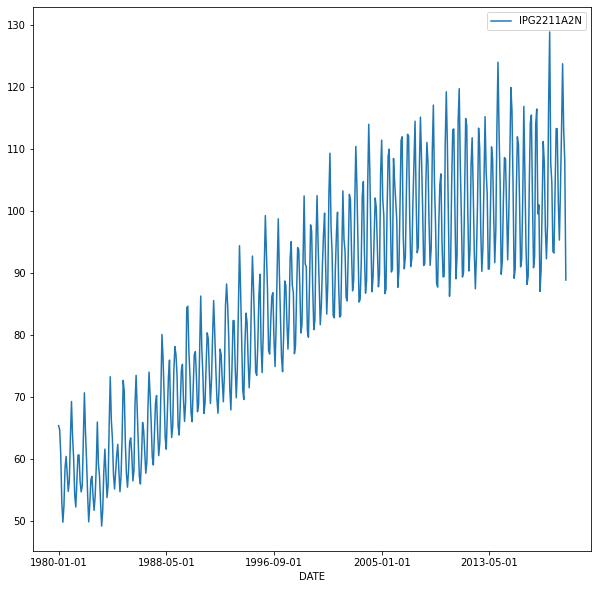

In [ ]:
dataframeFilter.plot(figsize=(10,10))

In [ ]:
X = dataframeFilter[['IPG2211A2N']].values
X = X.astype('float32')

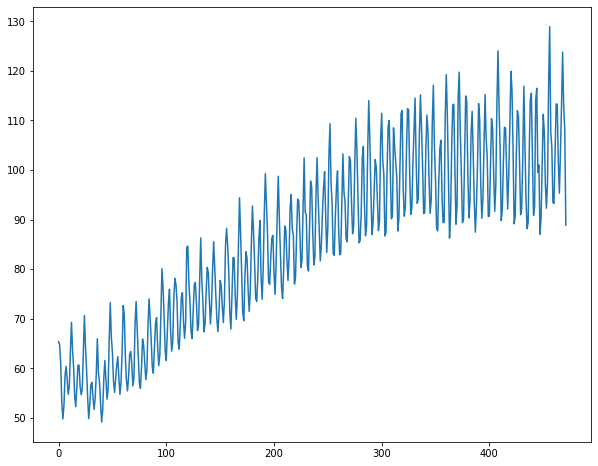

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(X)

In [ ]:
#Normaliza o dataset
scaler = MinMaxScaler(feature_range=(0, 1))

#scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size

train = X[0:train_size,:]
test =  X[train_size:len(X),:]

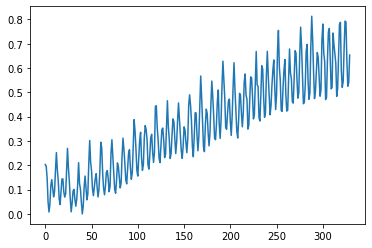

In [ ]:
plt.plot(train)

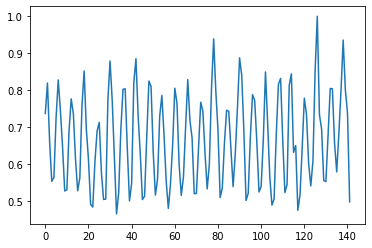

In [ ]:
plt.plot(test)

In [ ]:
# quantidade de atrasos
look_back = 3

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)


In [ ]:
X_train

In [ ]:
y_train

In [ ]:
X_train.shape

(326, 3)

In [ ]:
# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
X_train[1]

array([[0.19566226],
       [0.14685893],
       [0.04942161]], dtype=float32)

In [ ]:
y_train[1]

0.007882237

In [ ]:
X_train.shape

(326, 3, 1)

In [ ]:
# Cria e treina a rede LSTM
model = Sequential()
model.add(LSTM(8, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

In [ ]:
# Predições
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [ ]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [ ]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.30 RMSE
Test Score: 6.46 RMSE


In [ ]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [ ]:
# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-2, :] = testPredict

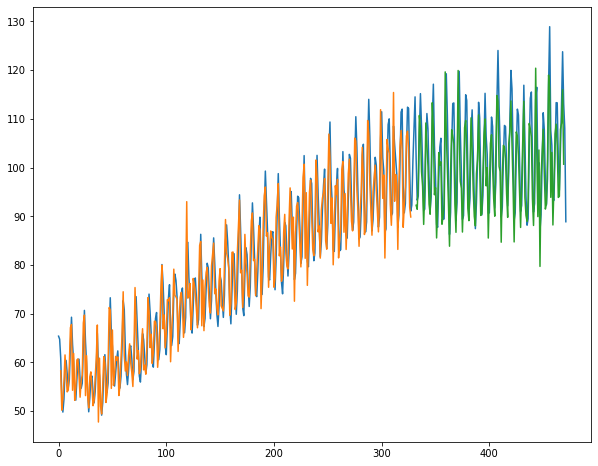

In [ ]:
# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(10,8))
plt.plot(scaler.inverse_transform(X))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()